In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.autograd import Variable

import torchvision
import numpy as np
import os
cwd = os.getcwd()
from PIL import Image
import time
import copy
import random
import cv2
import re
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import visdom
%matplotlib inline

## Pytorch data loader and transforms

### 데이터셋의 평균과 표준편차

In [2]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

### Define data augmentation and transforms

In [9]:
chosen_transforms = {'train': transforms.Compose([
        transforms.RandomResizedCrop(size=227),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'val': transforms.Compose([
        transforms.Resize(227),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'test': transforms.Compose([
        transforms.Resize(227),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
])
}

### Create the data loader

In [10]:
def load_dataset(format, batch_size):
    data_path = os.path.join(cwd, format)
    dataset = datasets.ImageFolder(
        root=data_path,
        transform= chosen_transforms[format]
    )
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        shuffle=True
    )
    return data_loader, len(dataset), dataset.classes

In [11]:
## Set code to run on device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
train_loader, train_size, class_names = load_dataset('train', 8)
print("Train Data Set size is: ", train_size)
print("Class Names are: ", class_names)
inputs, classes = next(iter(train_loader))
print(inputs.shape, classes.shape)

Train Data Set size is:  32010
Class Names are:  ['Negative', 'Positive']
torch.Size([8, 3, 227, 227]) torch.Size([8])


In [13]:
test_loader, test_size, class_name = load_dataset('test', 8)
print("Train Data Set size is: ", test_size)
print("Class Names are: ", class_names)
inputs, classes = next(iter(test_loader))
print(inputs.shape, classes.shape)

Train Data Set size is:  14
Class Names are:  ['Negative', 'Positive']
torch.Size([8, 3, 227, 227]) torch.Size([8])


### Visualize the Augmented Data Set

In [14]:
# Visualize some images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

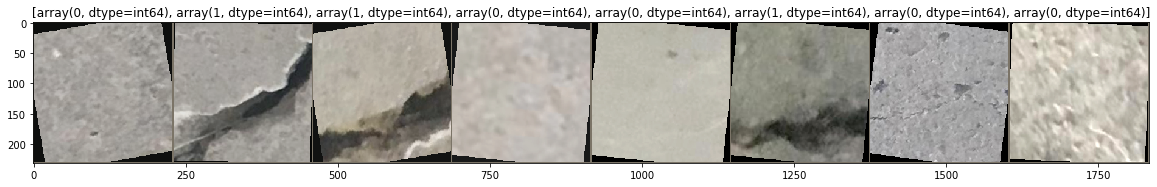

In [15]:
# Grab some of the training data to visualize
inputs, classes = next(iter(train_loader))
# class_names = chosen_datasets['train'].classes
# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

idx_to_class = {0:'Negative', 1:'Positive'}
plt.figure(figsize=(20,10))
imshow(out, title=[x.data.numpy() for x in classes])

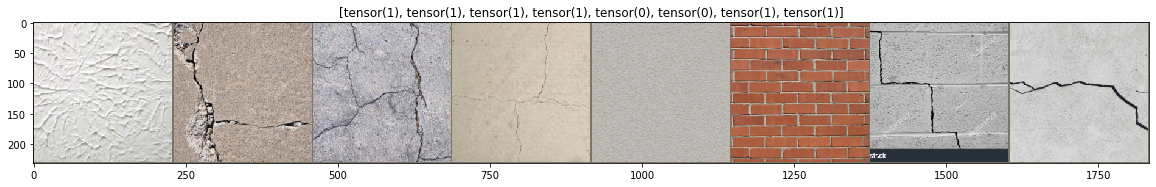

In [16]:
# Grab some of the training data to visualize
inputs, classes = next(iter(test_loader))
# class_names = chosen_datasets['train'].classes
# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

idx_to_class = {0:'Negative', 1:'Positive'}
plt.figure(figsize=(20,10))
imshow(out, title=[x for x in classes])

## Set up Pretrained Model
- pretrained model: resnet
- 파라미터 동결 후 마지막 레이어 fine-tuning

In [17]:
## Load pretrained model
resnet50 = models.resnet50(pretrained=True)

# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

## Change the final layer of the resnet model
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features
 
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 2)
)

# Convert model to be used on GPU
resnet50 = resnet50.to(device)

from torchsummary import summary
print(summary(resnet50, (3, 227, 227)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 114, 114]           9,408
       BatchNorm2d-2         [-1, 64, 114, 114]             128
              ReLU-3         [-1, 64, 114, 114]               0
         MaxPool2d-4           [-1, 64, 57, 57]               0
            Conv2d-5           [-1, 64, 57, 57]           4,096
       BatchNorm2d-6           [-1, 64, 57, 57]             128
              ReLU-7           [-1, 64, 57, 57]               0
            Conv2d-8           [-1, 64, 57, 57]          36,864
       BatchNorm2d-9           [-1, 64, 57, 57]             128
             ReLU-10           [-1, 64, 57, 57]               0
           Conv2d-11          [-1, 256, 57, 57]          16,384
      BatchNorm2d-12          [-1, 256, 57, 57]             512
           Conv2d-13          [-1, 256, 57, 57]          16,384
      BatchNorm2d-14          [-1, 256,

In [18]:
resnet50.load_state_dict(torch.load('resnet50.pth'))

<All keys matched successfully>

In [11]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Define Optimizer and Loss Function
- Optimizaer: Adam
- Loss Function: Cross Entropy
- 학습속도 조절: 3 epoch 마다 learning rate를 0.1씩 감소시킨다. 

In [19]:
# Define Optimizer and Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters())

# optimizer = optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [20]:
dataloaders = {}
dataset_sizes = {}
batch_size = 256
dataloaders['train'], dataset_sizes['train'], class_names = load_dataset('train', batch_size)
dataloaders['val'], dataset_sizes['val'], _ = load_dataset('val', batch_size)
idx_to_class = {0:'Negative', 1:'Positive'}

In [35]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/crack_detection_2')


In [36]:
images, labels = iter(dataloaders['train']).next()

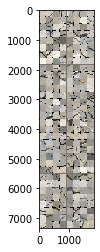

In [14]:

img_grid = torchvision.utils.make_grid(images)

imshow(img_grid)

writer.add_image('crack_detection_2', img_grid)

In [28]:
# for inputs, labels in dataloaders['train']:

#     img_grid = torchvision.utils.make_grid(inputs)
    
#     imshow(img_grid)

#     writer.add_image('crack_detection_2', img_grid)

## Start training

In [52]:
# visdom

# viz = visdom.Visdom()

# viz_train_loss = viz.line(
#     X=np.array([0]),
#     Y=np.array([0.16]),
#     opts = dict(title = "Training Loss")  
# )
# viz_val_loss = viz.line(
#     X=np.array([0]),
#     Y=np.array([0.04]),
#     opts = dict(title = "Validation Loss") 
# )

train_loss_list = []
val_loss_list = []

train_acc_list = []
val_acc_list = []

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # We need to zero the gradients, don't forget it
                # 역전파 단계 전에, Optimizer 객체를 사용하여 (모델의 학습 가능한 가중치인)
                # 갱신할 변수들에 대한 모든 변화도를 0으로 만듭니다. 이렇게 하는 이유는
                # 기본적으로 .backward()를 호출할 때마다 변화도가 버퍼(buffer)에 (덮어쓰지 않고)
                # 누적되기 때문입니다.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
            
                
            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc)
            else:
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc)            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

        
    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [22]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Epoch 0/5
----------
Iterating through data...
train Loss: 0.3569 Acc: 0.8579
Iterating through data...
val Loss: 0.1247 Acc: 0.9675

Epoch 1/5
----------
Iterating through data...
train Loss: 0.2096 Acc: 0.9261
Iterating through data...
val Loss: 0.0674 Acc: 0.9825

Epoch 2/5
----------
Iterating through data...
train Loss: 0.1868 Acc: 0.9322
Iterating through data...
val Loss: 0.0648 Acc: 0.9817

Epoch 3/5
----------
Iterating through data...
train Loss: 0.1745 Acc: 0.9375
Iterating through data...
val Loss: 0.0615 Acc: 0.9830

Epoch 4/5
----------
Iterating through data...
train Loss: 0.1750 Acc: 0.9357
Iterating through data...
val Loss: 0.0580 Acc: 0.9842

Epoch 5/5
----------
Iterating through data...
train Loss: 0.1749 Acc: 0.9362
Iterating through data...
val Loss: 0.0569 Acc: 0.9835

Training complete in 9m 22s
Best val Acc: 0.984230


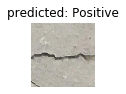

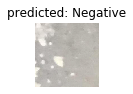

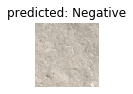

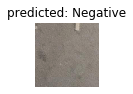

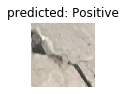

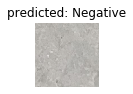

In [63]:
base_model = train_model(resnet50, criterion, optimizer, exp_lr_scheduler, num_epochs=6)
visualize_model(base_model)
plt.show()

In [ ]:
plt.plot(range(1, 7), val_loss_list, label="Training")
plt.plot(range(1, 7), train_loss_list, label="Validation")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.plot(range(1, 7), val_acc_list, label="Training")
plt.plot(range(1, 7), train_acc_list, label="Validation")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [11]:
# 모델의 state_dict 출력
print("Model's state_dict:")
for param_tensor in resnet50.state_dict():
    print(param_tensor, "\t", resnet50.state_dict()[param_tensor].size())

# 옵티마이저의 state_dict 출력
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([64, 3, 7, 7])
bn1.weight 	 torch.Size([64])
bn1.bias 	 torch.Size([64])
bn1.running_mean 	 torch.Size([64])
bn1.running_var 	 torch.Size([64])
bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv1.weight 	 torch.Size([64, 64, 1, 1])
layer1.0.bn1.weight 	 torch.Size([64])
layer1.0.bn1.bias 	 torch.Size([64])
layer1.0.bn1.running_mean 	 torch.Size([64])
layer1.0.bn1.running_var 	 torch.Size([64])
layer1.0.bn1.num_batches_tracked 	 torch.Size([])
layer1.0.conv2.weight 	 torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight 	 torch.Size([64])
layer1.0.bn2.bias 	 torch.Size([64])
layer1.0.bn2.running_mean 	 torch.Size([64])
layer1.0.bn2.running_var 	 torch.Size([64])
layer1.0.bn2.num_batches_tracked 	 torch.Size([])
layer1.0.conv3.weight 	 torch.Size([256, 64, 1, 1])
layer1.0.bn3.weight 	 torch.Size([256])
layer1.0.bn3.bias 	 torch.Size([256])
layer1.0.bn3.running_mean 	 torch.Size([256])
layer1.0.bn3.running_var 	 torch.Size([256])
layer1.0.bn3.num

layer3.3.bn1.weight 	 torch.Size([256])
layer3.3.bn1.bias 	 torch.Size([256])
layer3.3.bn1.running_mean 	 torch.Size([256])
layer3.3.bn1.running_var 	 torch.Size([256])
layer3.3.bn1.num_batches_tracked 	 torch.Size([])
layer3.3.conv2.weight 	 torch.Size([256, 256, 3, 3])
layer3.3.bn2.weight 	 torch.Size([256])
layer3.3.bn2.bias 	 torch.Size([256])
layer3.3.bn2.running_mean 	 torch.Size([256])
layer3.3.bn2.running_var 	 torch.Size([256])
layer3.3.bn2.num_batches_tracked 	 torch.Size([])
layer3.3.conv3.weight 	 torch.Size([1024, 256, 1, 1])
layer3.3.bn3.weight 	 torch.Size([1024])
layer3.3.bn3.bias 	 torch.Size([1024])
layer3.3.bn3.running_mean 	 torch.Size([1024])
layer3.3.bn3.running_var 	 torch.Size([1024])
layer3.3.bn3.num_batches_tracked 	 torch.Size([])
layer3.4.conv1.weight 	 torch.Size([256, 1024, 1, 1])
layer3.4.bn1.weight 	 torch.Size([256])
layer3.4.bn1.bias 	 torch.Size([256])
layer3.4.bn1.running_mean 	 torch.Size([256])
layer3.4.bn1.running_var 	 torch.Size([256])
layer3.4.

NameError: name 'optimizer' is not defined

## Inference

In [23]:
correct = 0
for data, target in test_loader:
    with torch.no_grad():
        data, target = Variable(data).cuda(), Variable(target).cuda()
        output = resnet50(data)
        prediction = output.data.max(1)[1]
        correct += prediction.eq(target.data).sum()

In [24]:
print('Test set: Accuracy: {:.2f}%'.format(100. * correct / len(test_loader.dataset)))

Test set: Accuracy: 78.57%


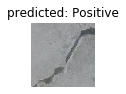

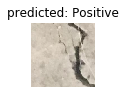

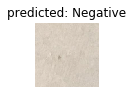

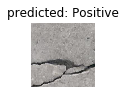

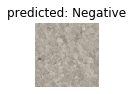

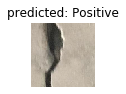

In [41]:
visualize_model(resnet50)

In [46]:
def evaluate(model):
    
    correct = 0
    for data, target in test_loader:
        with torch.no_grad():
            data, target = Variable(data).cuda(), Variable(target).cuda()
            output = resnet50(data)
            prediction = output.data.max(1)[1]
            correct += prediction.eq(target.data).sum()
    
    return correct

In [51]:
correct = evaluate(resnet50)

print('Test set: Accuracy: {:.2f}%'.format(100. * correct / len(test_loader.dataset)))

Test set: Accuracy: 71.43%


In [52]:
def predict(model, test_image, print_class = False):
     
    transform = chosen_transforms['val']
      
    test_image_tensor = transform(test_image)
 
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227)
     
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(1, dim=1)
        class_name = idx_to_class[topclass.cpu().numpy()[0][0]]
        if print_class:
            print("Output class :  ", class_name)
    return class_name

In [53]:
def predict_on_crops(input_image, height=227, width=227, save_crops = False):
    im = cv2.imread(input_image)
    imgheight, imgwidth, channels = im.shape
    k=0
    output_image = np.zeros_like(im)
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            a = im[i:i+height, j:j+width]
            ## discard image cropss that are not full size
            predicted_class = predict(resnet50,Image.fromarray(a))
            ## save image
            file, ext = os.path.splitext(input_image)
            image_name = file.split('/')[-1]
            folder_name = 'out_' + image_name
            ## Put predicted class on the image
            if predicted_class == 'Positive':
                color = (0,0, 255)
            else:
                color = (0, 255, 0)
            cv2.putText(a, predicted_class, (20,70), cv2.FONT_HERSHEY_SIMPLEX , 0.7, color, 1, cv2.LINE_AA) 
            b = np.zeros_like(a, dtype=np.uint8)
            b[:] = color
            add_img = cv2.addWeighted(a, 0.9, b, 0.1, 0)
            ## Save crops
            if save_crops:
                if not os.path.exists(os.path.join('real_images', folder_name)):
                    os.makedirs(os.path.join('real_images', folder_name))
                filename = os.path.join('real_images', folder_name,'img_{}.png'.format(k))
                cv2.imwrite(filename, add_img)
            output_image[i:i+height, j:j+width,:] = add_img
            k+=1
    ## Save output image
    cv2.imwrite(os.path.join('real_images','predictions', folder_name+ '.jpg'), output_image)
    return output_image

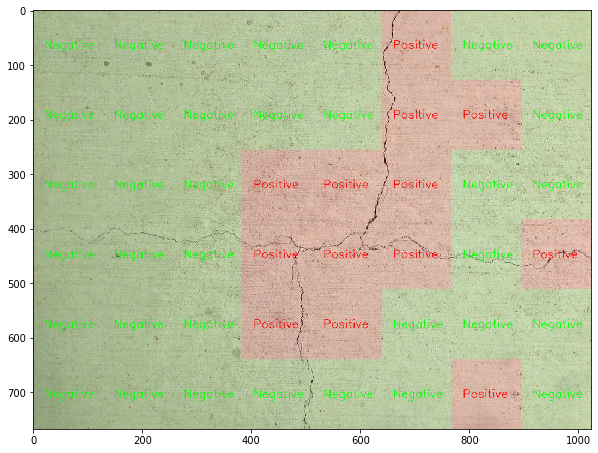

In [54]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('real_images/concrete_crack1.jpg', 128, 128)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

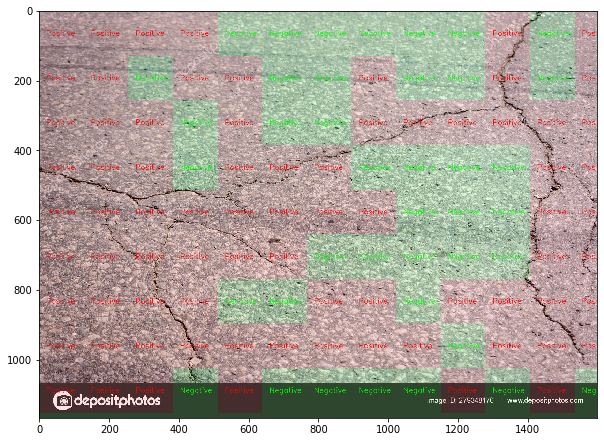

In [44]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('real_images/road_surface_crack3.jpg', 128, 128)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

--- 
## 추가 코드

visdom

In [23]:
import visdom
vis = visdom.Visdom()

textwindow = vis.text("Hello Pytorch")

Setting up a new session...


In [24]:

for i, data in enumerate(train_loader):
    img, label = data
    
    # 이미지 한개만 보는 기능
    vis.image(img[0])
    
    # 이미지를 다 보고 싶을 떄
    vis.images(img)
    break

In [28]:
# plot 그리는 방법
# Y값만 넣어주게 되면, X의 범위는 0~1로 지정된다
plot = vis.line(Y=torch.randn(5))

In [29]:
# 원하는 X값
plot = vis.line(Y=torch.randn(5), X=np.array([0, 1, 2, 3, 4]))

In [30]:
# plot을 업데이트하려면?
# update할 y값을 넣어주고, update 될 X값의 위치를 넣어주고,
# update할 plot의 변수명을 win = 에 넣어주고
# update='append'
vis.line(Y=torch.randn(1), X=np.array([5]), win=plot, update="append")

'window_38ad1fa56a3e98'

In [31]:
for i in range(500):
    vis.line(Y=torch.rand(1), X=np.array([i+5]), win=plot, update="append")

In [32]:
vis.line(Y=torch.Tensor([[0., 0.], [1., 1.]]))

'window_38ad2069113f9c'